## Step 1: Importing Libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

## Step 2: Loading dataset

In [57]:
from google.colab import drive
drive.mount("/content/gdrive")
data_dir = "/content/gdrive/MyDrive/ASL Sign language";

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Transforming Dataset

In [58]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageFolder(data_dir, transform = transform)

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

print("Number of classes: ",len(dataset.classes))
print("Number of images: ",len(dataset.samples))

Number of classes:  3
Number of images:  9010


In [60]:
# Splitting dataset into train, validation and test

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
extra_size = int(0 * len(dataset))
train_ds, val_ds, test_ds, extra_ds = random_split(dataset, [train_size, val_size, test_size, extra_size])
len(train_ds), len(val_ds), len(test_ds)

(6307, 1802, 901)

In [61]:
from torch.utils.data import DataLoader
batch_size = 64

In [62]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 50, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 50, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 50, pin_memory = True)

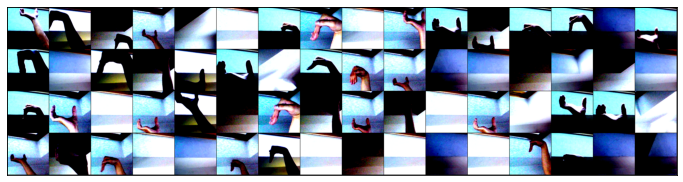

In [64]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [65]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss.detach(), 'train_acc': acc}

    def testing_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def training_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
       
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
       
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['test_loss'], result['val_loss'], result['train_acc'], result['test_acc'], result['val_acc']))

In [66]:
from torchvision.models import resnet18, ResNet18_Weights

model = torchvision.models.resnet18()

In [67]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [68]:
device = get_default_device()
device

device(type='cuda')

In [69]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
from torch.nn.modules import loss
from torch.optim.adam import Adam
num_epochs = 10
lr =  0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss();

In [71]:
from torch.autograd import Variable
#Model Training and saving best Model
best_accuracy = 0.0
train_acc_list = []
test_acc_list = []
val_acc_list = []
train_loss_list = []
test_loss_list = []
val_loss_list = []
epo = []
for epoch in range(num_epochs):
  #evaluation and training on training dataset
  model.train()
  train_acc = 0.0
  train_loss = 0.0

  for i, (images, labels) in enumerate(train_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    # scheduler.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = train_acc / train_size
  train_loss = train_loss / train_size
      
  #Evaluation on testing dataset
  model.eval()

  test_acc = 0.0
  correct1 = 0
  total1 = 0
  test_loss = 0.0

  for i, (images, labels) in enumerate(test_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    test_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    test_acc += int(torch.sum(prediction==labels.data))
    total1 += labels.size(0)
    correct1 += (prediction == labels).sum().item()
  
  test_acc = test_acc / test_size
  test_loss = test_loss / test_size

  val_acc = 0.0
  correct2 = 0
  total2 = 0
  val_loss = 0.0

  for i, (images, labels) in enumerate(val_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    val_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))
    total2 += labels.size(0)
    correct2 += (prediction == labels).sum().item()

  val_loss = val_loss / val_size
  val_acc = val_acc / val_size
  print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+ ' Train Accuracy: '+str(train_acc) + 
                              ' Test Accuracy: '+str(test_acc) + 
                               ' Validation Loss: '+str(val_loss)+ ' Validation Accuracy: '+str(val_acc))
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  val_acc_list.append(val_acc)
  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  val_loss_list.append(val_loss)
  epo.append(epoch+1)

  if(test_acc>best_accuracy):
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = test_acc
print('Test Accuracy of the model on the {} test images: {} %'.format(total1, (correct1 / total1) * 100))
print('Test Accuracy of the model on the {} validation images: {} %'.format(total2, (correct2 / total2) * 100))

Epoch: 1 Train Loss: tensor(0.9419) Train Accuracy: 0.8630093546852703 Test Accuracy: 0.97669256381798 Validation Loss: tensor(0.0485) Validation Accuracy: 0.9694783573806881
Epoch: 2 Train Loss: tensor(0.0227) Train Accuracy: 0.9963532582844459 Test Accuracy: 1.0 Validation Loss: tensor(0.0148) Validation Accuracy: 1.0
Epoch: 3 Train Loss: tensor(0.0100) Train Accuracy: 0.9990486760742032 Test Accuracy: 0.9977802441731409 Validation Loss: tensor(0.0069) Validation Accuracy: 0.9977802441731409
Epoch: 4 Train Loss: tensor(0.0084) Train Accuracy: 0.9988901220865705 Test Accuracy: 1.0 Validation Loss: tensor(0.0024) Validation Accuracy: 1.0
Epoch: 5 Train Loss: tensor(0.0025) Train Accuracy: 0.9996828920247344 Test Accuracy: 1.0 Validation Loss: tensor(0.0009) Validation Accuracy: 1.0
Epoch: 6 Train Loss: tensor(0.0012) Train Accuracy: 1.0 Test Accuracy: 1.0 Validation Loss: tensor(0.0011) Validation Accuracy: 1.0
Epoch: 7 Train Loss: tensor(0.0008) Train Accuracy: 1.0 Test Accuracy: 1.0 

<ipython-input-74-32b50d6e72e6>:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-rx" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(train_acc_list, '-rx', label='Train Acc', marker = 'o')
<ipython-input-74-32b50d6e72e6>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-gx" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(test_acc_list, '-gx', label='Test Acc', marker = 'o')
<ipython-input-74-32b50d6e72e6>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-bx" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(val_acc_list, '-bx', label='Val Acc', marker = 'o')


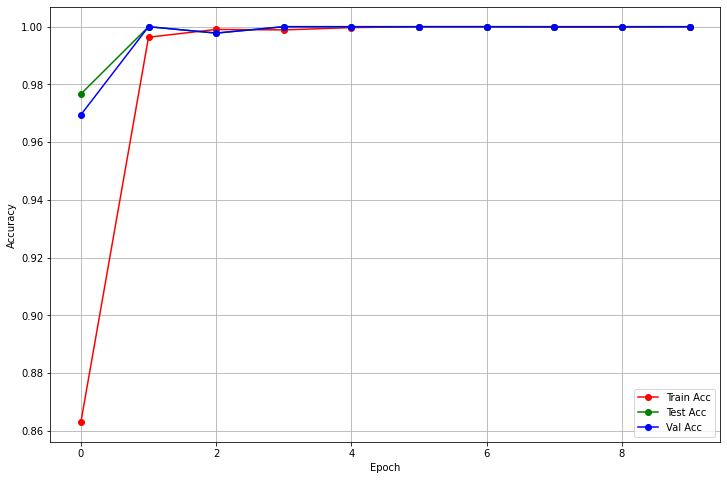

<ipython-input-74-32b50d6e72e6>:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ":cx" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(train_loss_list, ':cx', label='Train Loss', marker = 'o')
<ipython-input-74-32b50d6e72e6>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ":yx" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(val_loss_list, ':yx', label='Val Loss', marker = 'o')


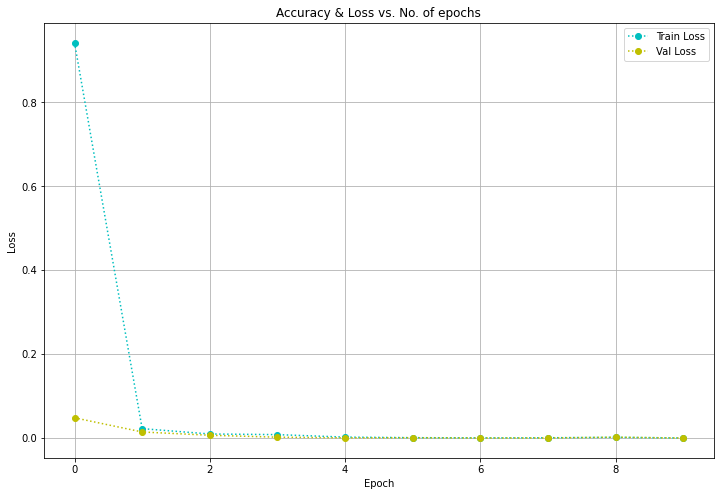

In [74]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
plt.plot(train_acc_list, '-rx', label='Train Acc', marker = 'o')
plt.plot(test_acc_list, '-gx', label='Test Acc', marker = 'o')
plt.plot(val_acc_list, '-bx', label='Val Acc', marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#ax.tick_params('vals', colors='r')
plt.grid()
plt.show()

# Get second axis
ax2 = ax.twinx()
plt.plot(train_loss_list, ':cx', label='Train Loss', marker = 'o')
plt.plot(val_loss_list, ':yx', label='Val Loss', marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Loss vs. No. of epochs');

plt.grid()
plt.show()

# New Section

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


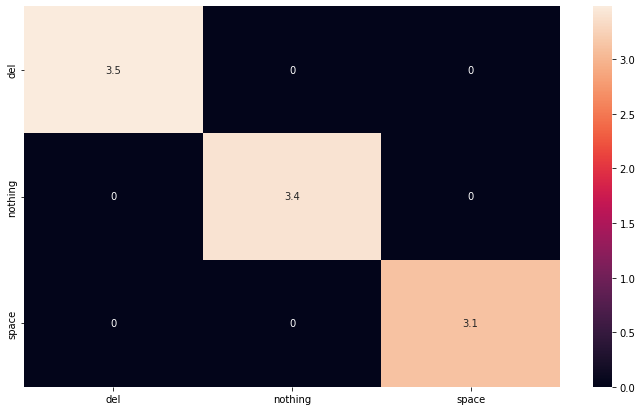

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic',
        'trash')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in dataset.classes],
                     columns = [i for i in dataset.classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def modelMetrics(modelName,data_loader):
  y_pred = []
  y_true = []
  # iterate over test data
  for data in data_loader:
    images, labels = data[0].to(device), data[1].to(device)
    output = modelName(images)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) 
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) 
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_pred, y_true)*100
  print('Accuracy: %.2f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_pred, y_true,average="weighted")*100
  print('Precision: %.2f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_pred, y_true,average="weighted")*100
  print('Recall: %.2f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_pred, y_true,average="weighted")*100
  print('F1 score: %.2f' % f1)

modelMetrics(model, test_dl)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 100.00
Precision: 100.00
Recall: 100.00
F1 score: 100.00
